In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

plt.rcParams['figure.figsize'] = (15.0, 8.0)

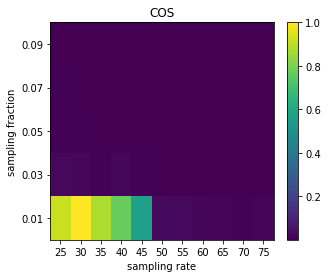

In [3]:
def heatmap_sf_sr_recon_error(sf_range, sr_range, errors):
    fig = plt.figure(figsize=[5, 4])
    plt.rc('font', size=10)
    
    # plt.plot()
    ax = plt.axes()
    # plt.plot(beta_opt, gamma_opt, "ro")

    X, Y = np.meshgrid(sr_range, sf_range, indexing='ij')
    Z = errors.reshape(len(sr_range), len(sf_range))

    c = ax.pcolormesh(X, Y, Z) # , cmap='viridis', vmin=z_min, vmax=z_max)
    # ax.axis([X.min(), X.max(), Y.min(), Y.max()])

    ax.set_xlabel("sampling rate")
    ax.set_xticks(sr_range)
    ax.set_ylabel("sampling fraction")
    ax.set_yticks(sf_range)
    ax.set_title("COS")
    # ax.plot(beta_opt, gamma_opt, "ro")
    fig.colorbar(c, ax=ax)
    # fig.savefig(figpath)
    plt.show()
    
mse = [2.118698600320954, 0.4264235441805948, 0.23822630844099071, 0.20689894933684855, 0.08179201689773634, 2.2506459599867297, 0.4361775598188958, 0.28659993733247136, 0.08744856847992419, 0.0732864746349093, 2.167304785566338, 0.2582870914352997, 0.07478826860249567, 0.08504810899867897, 0.027660263129608294, 2.0826489226719773, 0.4974349673297324, 0.10023255899534426, 0.043216215279435435, 0.012896733064577717, 1.890956325776356, 0.245688530621947, 0.1642245597373079, 0.04092778340638934, 0.009768291372807237, 0.6236907857945042, 0.07233869787634145, 0.04904438203387639, 0.006495148753355689, 0.004773276637086853, 0.45381613699741424, 0.09717807985892747, 0.020318993450127804, 0.0048653611344645215, 0.005854854988494881, 0.4079406685982311, 0.05752508146084986, 0.03293372173454906, 0.005337024286452811, 0.0016303156632120727, 0.32382769815856427, 0.04637524040669229, 0.007910584000797893, 0.011292997260871044, 0.0020378982544017655, 0.2728995121818533, 0.034334197749544375, 0.0279716691639176, 0.013906723654300636, 0.001582039421033094, 0.2951727273794584, 0.024794543470055355, 0.004180796621427102, 0.009449785715426139, 0.0011158319481410295]
cos = [0.9170881306593054, 0.020395174146597972, 0.00566981610523154, 0.0039384215167377334, 0.0007302953545714752, 1.0004203497002622, 0.0188219007392203, 0.007393527964160818, 0.0008502044459147706, 0.0005899466741239312, 0.8769843605026652, 0.006205772549262689, 0.0005508984920948867, 0.0007414948727852977, 7.253485673319737e-05, 0.7693052304633172, 0.01950434449772509, 0.001064726690196749, 0.0002024321084277414, 1.8883842521799643e-05, 0.5646786756984006, 0.006642873884647016, 0.0029412072261973954, 0.00018737105799071507, 1.0644817274751972e-05, 0.027019925328360506, 0.0005010397101369302, 0.00026940280691556406, 4.361747626302481e-06, 2.5351871332235376e-06, 0.021951737749359213, 0.0008852483031792646, 3.9699370302459513e-05, 2.5529419176439916e-06, 3.841655672132127e-06, 0.012003482167032176, 0.00033436962588717645, 0.00011804230235890056, 3.15399044503728e-06, 2.913723184949646e-07, 0.00905803211426015, 0.00022103601155998298, 6.564199006353633e-06, 1.4181103266008854e-05, 4.6520245389203296e-07, 0.005834684113153243, 0.0001240059951487238, 8.686624768983187e-05, 2.1601343854538158e-05, 2.750607249746295e-07, 0.008060298714766545, 5.8996589237358954e-05, 1.900175701008422e-06, 1.0013390652097165e-05, 1.3908894402892003e-07]

sr_range = range(25, 76, 5)
sf_range = np.arange(0.01, 0.11, 0.02)
heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(cos))
# heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(mse))
    

In [164]:
def vis_recon_error(ax, nq_range, inst_range, sf_range, errors, plot_type, title: str, start: int=1):
    errors = errors.reshape(len(nq_range), len(inst_range), len(sf_range))

    
    print("shape before transpose: ", errors.shape)
    # print(errors)
    errors = errors.transpose(0, 2, 1)
    print("shape after transpose: ", errors.shape)

    for i in range(len(nq_range)):
        if plot_type == 'box':
            ax.boxplot(errors[0])

        elif plot_type == 'quantiles':
            y = errors[i, start:] # shape = (len(sf_range), len(inst_range))
            y = np.nanquantile(y, q=(0.25, 0.5, 0.75), axis=1) 
            # print(y)
            x = np.array(sf_range[start:])
            # x = np.range(len(sf_range[start:]))
            # print(x)
            label = f"{nq_range[i]} qubits"
            fmt = "" 
            ax.errorbar( 
                x,
                # y[1][x],
                y[1], 
                # yerr=(y[1][x] - y[0][x], y[2][x] - y[1][x]), 
                yerr=(y[1] - y[0], y[2] - y[1]), 
                label=label, 
                alpha=0.75, 
                fmt=fmt, 
                capsize=3, 
                capthick=1, 
            ) 
            # plt.fill_between(x, y1=y[0][x], y2=y[2][x], alpha=0.25)
            ax.fill_between(x, y1=y[0], y2=y[2], alpha=0.25)
        elif plot_type == 'line':
            ax.plot(sf_range[start:],
                errors[i,start:,:].mean(axis=-1),
                label=f"{nq_range[i]} qubits")
        else:
            raise NotImplementedError()

    ax.set_title(title, y=-0.32)
    # ax.legend()
    # plt.show()
    return


def vis_maxcut(ax, p: int, noise: str, error_type: str):
    
    if p == 1 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [16, 20, 24, 30]
        inst_range = list(range(16))
        title = f"(A) "
        title += f"{p=}, {noise}" # , {len(inst_range)} instances"
    elif p == 1 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(B) "
        title += f"{p=}, noisy" # , {len(inst_range)} instances"
    elif p == 2 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True)
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(C) "
        title += f"{p=}, {noise}" # , {len(inst_range)} instances"
    elif p == 2 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=2/recon_error_ns=[12, 16]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            , allow_pickle=True
        )
        title = "(D) "
        nq_range = [12, 16]
        inst_range = list(range(8))
        title += f"{p=}, noisy" # , {len(inst_range)} instances"

    # if noise == 'depolar-0.001-0.005':
    #     # depolarizing 0.001, 0.005
    #     mse = [0.5294567889697064, 0.10504512962369626, 0.0313981299420259, 0.012503321574744162, 0.008140374429632507, 0.8424334405179074, 0.10568723568802518, 0.03212506658687189, 0.014080103905186459, 0.009296142398008756, 0.526865075200324, 0.12747919612932213, 0.06309042154958099, 0.049028926963782395, 0.017344741404916143, 0.5292877712080678, 0.12807155118871388, 0.06338557278944737, 0.04927365907019386, 0.01742941715973452, 1.9361662554992944, 0.11117192831199525, 0.05794935815783304, 0.042218665732938074, 0.031913622196141994, 1.9274262480485385, 0.11380618083255489, 0.06048147435362607, 0.042544439403038134, 0.032231339880888894]
    #     cos = [0.03345611343649668, 0.001882758932071349, 0.00018351884817768838, 3.2312424903535586e-05, 1.3707400878582021e-05, 0.1189645214978915, 0.00180777477491334, 0.0001907390154839428, 4.040555030127013e-05, 1.7545841520250072e-05, 0.023844061448096587, 0.002032726517411043, 0.0004999788199564481, 0.00030430659574010033, 3.7662019811590675e-05, 0.02382890847269281, 0.0020325601979672703, 0.0004999731174260003, 0.0003044908765591492, 3.767714656655041e-05, 0.3036874338519604, 0.0008274828744364582, 0.0002466740593143335, 0.0001358167458470616, 7.858596328635947e-05, 0.29930637856623044, 0.0008437189310439575, 0.0002633779178375928, 0.0001353103607633077, 7.849847216112593e-05]
        
    # elif noise == 'depolar-0.003-0.007':
    #     mse = [0.5039391145820539, 0.10187541579824788, 0.030521028927380053, 0.012100274958501474, 0.007879699198447391, 0.8164015928099697, 0.10280057365192978, 0.031246832290654097, 0.013655930917672875, 0.00904611410285615, 0.5111357466189159, 0.12415765730594497, 0.06143917804136556, 0.047700887403396286, 0.016817643074515512, 0.5106162502837763, 0.12448309263267172, 0.06159363454853711, 0.047782653207815724, 0.016818108440983092, 1.8821332493158773, 0.10812472566677976, 0.05626310971617496, 0.040952219495018434, 0.030904712822065413, 1.8743446567979802, 0.11086259352599241, 0.05872780804047352, 0.04143577374538176, 0.031403123343349756]
    #     cos = [0.03136409094172088, 0.0018815084299171891, 0.00018399240948696605, 3.213134121327066e-05, 1.364762014444132e-05, 0.11782864549589178, 0.0018098338121567137, 0.00019087352646751654, 4.0206323897673535e-05, 1.7577098521237566e-05, 0.02374738664478715, 0.002033384390250359, 0.000500005455133401, 0.00030376060436587693, 3.733602140165715e-05, 0.023632971680983994, 0.0020339993226150543, 0.0005000360258804459, 0.00030330285893775955, 3.7151272810787006e-05, 0.30499961591915303, 0.0008297448762913939, 0.00024676532028444775, 0.00013542860375459487, 7.80946002396643e-05, 0.2968800883830971, 0.0008426220675257223, 0.00026143955952540043, 0.00013512567448970003, 7.84428741792409e-05]
    # else:
    #     raise NotImplementedError()

    if error_type == 'NRMSE':
        errors = recon_error_data['mses']
    elif error_type == 'COS':
        errors = recon_error_data['coss'] 
    else:
        raise NotImplementedError()

    # title += f"{p=}, {noise}, {len(inst_range)} instances"
    sf_range = np.arange(0.01, 0.11, 0.02)
    # errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(errors))
    errors_noisy = vis_recon_error(ax, nq_range, inst_range, sf_range, np.array(errors), "quantiles", title)


shape before transpose:  (4, 16, 5)
shape after transpose:  (4, 5, 16)
shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)


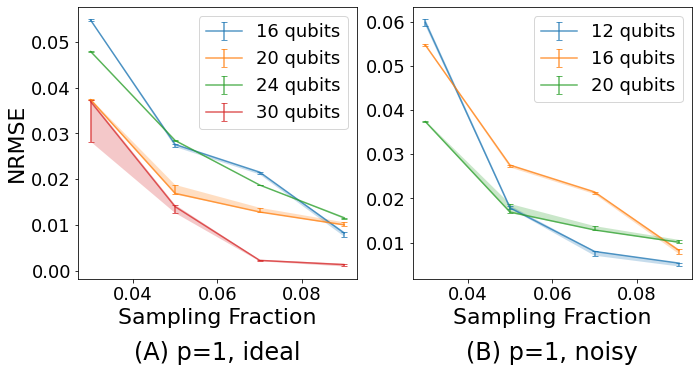

In [165]:
params = {'legend.fontsize': 18,
          'figure.figsize': (11, 5),
         'axes.labelsize': 22, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
plt.rcParams.update(params)
fig, axes = plt.subplots(1, 2) #, figsize=(14, 5))
# plt.rcParams['font.size'] = '16'

# Sec4A, ideal, p=1
vis_maxcut(axes[0], p=1, noise="ideal", error_type="NRMSE")

# Sec4B, noisy, p=1
vis_maxcut(axes[1], p=1, noise="depolar-0.003-0.007", error_type="NRMSE")

for i, ax in enumerate(axes):
    ax.set_xlabel("Sampling Fraction")
    if i == 0:
        ax.set_ylabel("NRMSE")
    # ax.text(x=0.01, y=0, s=title,
    #     horizontalalignment='left',
    #     verticalalignment='bottom')
    
    ax.legend()
    # ax.text(0.5, 0.5, str("A"),
    #        fontsize=18, ha='center')
        #    fontsize=18, ha='center')

# axes[1].set_xlabel('')
plt.savefig("paper_figs/recon_error_AB.pdf", bbox_inches="tight", dpi=1000)
plt.show()


shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)
shape before transpose:  (2, 8, 5)
shape after transpose:  (2, 5, 8)


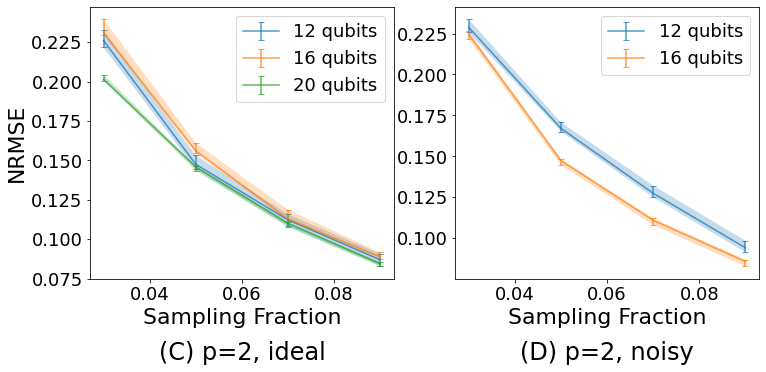

In [166]:
params = {'legend.fontsize': 18,
          'figure.figsize': (12, 5),
         'axes.labelsize': 22, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 2) #, figsize=(12, 5))
# plt.rcParams['font.size'] = '16'
# Sec4C, ideal, p=2
vis_maxcut(axes[0], p=2, noise="ideal", error_type="NRMSE")

# should be Sec4D, ideal, p=2
vis_maxcut(axes[1], p=2, noise="depolar-0.003-0.007", error_type="NRMSE")

for i, ax in enumerate(axes):
    ax.set_xlabel("Sampling Fraction")
    if i == 0:
        ax.set_ylabel("NRMSE")
    ax.legend()

plt.savefig("paper_figs/recon_error_CD.pdf", bbox_inches="tight", dpi=1000)
plt.show()


shape before transpose:  (4, 1, 5)
shape after transpose:  (4, 5, 1)


UnboundLocalError: local variable 'y' referenced before assignment

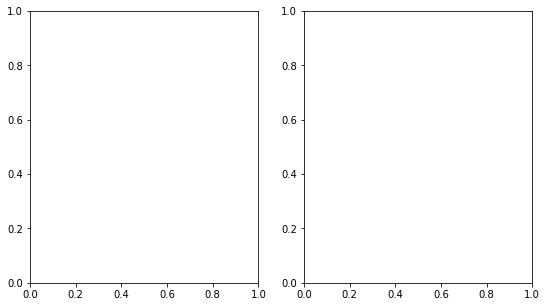

In [19]:

def vis_partition():
    recon_error_data = np.load(
        "figs/grid_search_recon/partition/sv-ideal-p=1/recon_error_ns=[12, 16, 20, 24]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        # "figs/grid_search_recon/partition/sv-ideal-p=2/recon_error_ns=[12, 16]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        , allow_pickle=True
    )
    nq_range = [12, 16, 20, 24]
    inst_range = [0]
    sf_range = np.arange(0.01, 0.11, 0.02)
    mses = recon_error_data['mses']
    coss = recon_error_data['coss']
    vis_recon_error(nq_range, inst_range, sf_range, mses, "quantiles", "partition, p=1")
    
vis_partition()

shape before transpose:  (4, 1, 5)
shape after transpose:  (4, 5, 1)


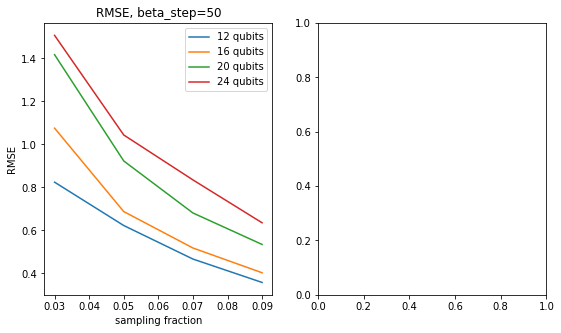

In [ ]:

def vis_sk_model():
    recon_error_data = np.load(
        "figs/grid_search_recon/skmodel/sv-ideal-p=2/recon_error_ns=[12, 16, 20, 24]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        , allow_pickle=True
    )
    nq_range = [12, 16, 20, 24]
    inst_range = [0]
    sf_range = np.arange(0.01, 0.11, 0.02)
    mses = recon_error_data['mses']
    coss = recon_error_data['coss']
    vis_recon_error(nq_range, inst_range, sf_range, mses, "line", "SK Model")
    
vis_sk_model()


read grid search data from figs/grid_search/maxcut/sv-depolar-0.001-0.02-p=2/maxcut-sv-depolar-0.001-0.02-n=20-p=2-seed=0-12-15.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-depolar-0.001-0.02-p=2/recon-cs_seed=20-sf=0.050-maxcut-sv-depolar-0.001-0.02-n=20-p=2-seed=0-12-15.npz
0.16467247392701384
reshape: (12, 12, 15, 15) -> (144, 225)
reshape: (12, 12, 15, 15) -> (144, 225)


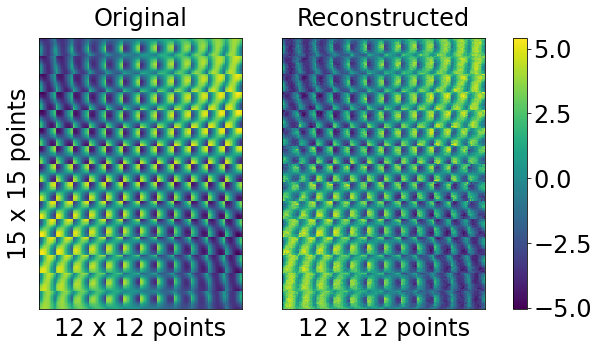

save to:  paper_figs/recon_p2.pdf


In [162]:
from data_loader import get_recon_landscape
from QAOAKit.compressed_sensing import cal_recon_error

def vis_landscapes(
        fig,
        axs,
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title_y,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # print("full_range =", full_range)

    tmp = []
    
    for ls in landscapes:
        if len(ls.shape) == 4:
            shape = ls.shape
            ls = ls.reshape(shape[0] * shape[1], shape[2] * shape[3])
            print(f"reshape: {shape} -> {ls.shape}")
            p = 2
        elif len(ls.shape) == 2:
            p = 1
            pass
        else:
            raise ValueError()
        tmp.append(ls)

    landscapes = tmp

    # plt.figure
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing='ij')
    # X, Y = np.meshgrid(full_range['beta'], full_range['gamma'], indexing='xy')
    
    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    # axs[1] = axs[0].twinx()
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx], y=title_y)
        if p == 1:
            axs[idx].set_xlabel('beta')
            axs[idx].set_ylabel('gamma')
        elif p == 2:
            # axs[idx].set_xlabel(r'$\beta\times\beta$')
            # axs[idx].set_ylabel('gamma x gamma')
            axs[idx].set_xlabel("12 x 12 points")
            if idx == 0:
                axs[idx].set_ylabel("15 x 15 points")

        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[0], true_optima[1], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, marker="o", color='purple', markersize=5, label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")
            axs[idx].plot(xs[-1], ys[-1], marker="s", color='white', markersize=12, label="last point")

        axs[idx].set_xticks([])
        axs[idx].set_yticks([])

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    save_dir = os.path.dirname(save_path)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # if os.path.exists(save_path):
    #     print("same path file exists, refuse to overwrite, please check")
    #     return
    # fig.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close('all')

    print("save to: ", save_path)

def vis_origin_and_recon_landscapes(
    n_qubits: int, p: int, problem: str, noise: str, seed: int, error_type: str
):
    method = 'sv'
    miti_method = ''
    sf = 0.05

    cs_seed = n_qubits
    if p == 1:
        bs = 50 # beta step
        gs = 2 * bs
    elif p == 2:
        bs = 12
        gs = 15

    data, data_fname, data_dir = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method
    )

    plot_range = data['plot_range']

    recon_dir = f"figs/grid_search_recon/{problem}/{method}-{noise}-p={p}"

    recon_fname = f"recon-cs_seed={cs_seed}-sf={sf:.3f}-{data_fname}"
    recon_path = f"{recon_dir}/{recon_fname}"

    origin = data['data']
    recon = get_recon_landscape(p, origin, sf, True, 
        recon_path, cs_seed)
            
    nrmse = cal_recon_error(origin.reshape(-1), recon.reshape(-1), error_type)
    print(nrmse)

    fig, axes = plt.subplots(nrows=1, ncols=2) #, figsize=(30, 22))

    vis_landscapes(
        fig,
        axes,
        landscapes=[origin, recon],
        labels=["Original", "Reconstructed"],
        full_range={
            "beta": plot_range['beta'],
            "gamma": plot_range['gamma'] 
        },
        true_optima=None,
        title_y=1.02,
        save_path=f'paper_figs/recon_p2.pdf',
        params_paths=[None, None]
    )

params = {'legend.fontsize': 24,
          'figure.figsize': (10, 5),
         'axes.labelsize': 24, #'x-large',
         'axes.titlesize': 24, #'x-large',
         'xtick.labelsize': 24,
         'ytick.labelsize': 24}
plt.rcParams.update(params)

vis_origin_and_recon_landscapes(20, 2, 'maxcut', 'depolar-0.001-0.02', 0, 'NRMSE')